# Time Series

In this problem, you will be analyzing and visualizing time-series data. Specifically, you will be working with Pittsburgh Port Authority's TrueTime data which is [publicly available](http://truetime.portauthority.org/bustime/login.jsp). If you're interested, you can request an API key and collect the data yourself, but we've already collected a subset of the available data for the purpose of this assignment.

We will be using [`pandas`](https://pandas.pydata.org/pandas-docs/stable/user_guide/) to work with this data.


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3

## TrueTime dataset

The bus data has been collected by querying the TrueTime API every minute. Each time, we make a request for vehicle information for every bus running on the 61A, 61B, 61C, and 61D bus routes. The results are given as XML, which we then parsed and stored within the `vehicles` table of a [sqlite](https://www.sqlite.org/index.html) database. (Ignore other tables in the database.)

| column    | data                                                                                            |
| --------- | ----------------------------------------------------------------------------------------------- |
| vid       | vehicle identifier                                                                              |
| tmstmp    | date and time of the last positional update of the vehicle                                      |
| lat       | latitude position of the vehicle in decimal degrees                                             |
| lon       | longitude position of the vehicle in decimal degrees                                            |
| hdg       | heading of vehicle as a 360 degree value (0 is north, 90 is east, 180 is south, and 270 is west |
| pid       | pattern ID of trip currently being executed                                                     |
| rt        | route that is currently being executed                                                          |
| des       | destination of the current trip                                                                 |
| pdist     | linear distance (feet) vehicle has traveled into the current pattern                            |
| spd       | speed as reported from the vehicle in miles per hour                                            |
| tablockid | TA's version of the scheduled block identifier for work currently behind performed              |
| tatripid  | TA's version of the scheduled trip identifier for the vehicle's current trip                    |

First, you will need to read in the data. We have dumped the raw form of the data into a sqlite database, which you can read directly into a pandas dataframe using `pd.read_sql_query`. You need to read the data in and do this:

1. Sometimes the TrueTime API returns a bogus result that has empty strings for the `vid`. You should remove all rows that have blank `vid`s.
2. SQLite does not enforce types on the data, so pandas reads most columns as objects even if the underlying type is an integer or float. To run numerical functions on them you need to convert numeric columns to the correct type.
3. You need to set the timestamps as `pd.DatetimeIndex` and set them to be the Dataframe index. (You may need to wrap the type conversion like this `... = pd.DatetimeIndex(...)` to make it work.) Pandas will prepare the data for efficient time-based querying accordingly. You also need to retain the original additional `tmstmp` column.

Note that strings show up as objects. This is because the underlying implementation of Pandas uses numpy arrays, which need fixed-size entries, so they store pointers to strings instead of the strings themselves. The types of your dataframes columns should match the datatypes in the first test case, namely

```python
{'vid': 'int64',
 'tmstmp': 'datetime64[ns]',
 'lat': 'float64',
 'lon': 'float64',
 'hdg': 'int64',
 'pid': 'int64',
 'rt': 'object',
 'des': 'object',
 'pdist': 'int64',
 'spd': 'int64',
 'tablockid': 'object',
 'tatripid': 'int64'}
```


In [13]:
import pandas as pd
import sqlite3

def load_data():
    """ Read the sqlite database, from the file "bus_aug23.db" into a pandas dataframe
    Returns:
        pd.DataFrame : a dataframe with the vehicle data 
    """
    conn = sqlite3.connect('bus_aug23.db')
    query = "SELECT * FROM vehicles"
    df = pd.read_sql_query(query, conn)

    # Remove rows where 'vid' is an empty string
    df = df[df['vid'] != '']

    # Convert necessary columns to appropriate types
    df['vid'] = df['vid'].astype('int64')
    df['tmstmp'] = pd.to_datetime(df['tmstmp'])
    df['lat'] = df['lat'].astype('float64')
    df['lon'] = df['lon'].astype('float64')
    df['hdg'] = df['hdg'].astype('int64')
    df['pid'] = df['pid'].astype('int64')
    df['rt'] = df['rt'].astype('object')
    df['des'] = df['des'].astype('object')
    df['pdist'] = df['pdist'].astype('int64')
    df['spd'] = df['spd'].astype('int64')
    df['tablockid'] = df['tablockid'].astype('object')
    df['tatripid'] = df['tatripid'].astype('int64')

    # Set tmstmp as the index
    df.set_index(pd.DatetimeIndex(df['tmstmp']), inplace=True)

    return df

## Splitting Data by Vehicle

Now that the data is loaded, we will split the `vehicle` dataframe into dataframes for each individual vehicle. (Note that the same vehicle will run different routes at different times; this is expected behavior.)

You use the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) feature of pandas to (as the name suggests) group the dataframe by the `vid` field. Convert the result into a list-of-dataframes.

Note that `groupby` doesn't create a copy of the underlying data. Instead, it creates a new dataframe that points to some rows within the original data; this is vastly more memory-efficient especially when working with image or video data. We also include a test to make sure you didn't accidentally copy it.

We strongly suggest you read the [`split-apply-combine` pattern](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) guide; that is a powerful pattern that we will be using repeatedly in this assignment.


In [14]:
def split_vehicles(df):
    """ Splits the dataframe into a list of dataframes for each individual vehicle. 
    Args: 
        df (pd.DataFrame): A dataframe containing all data
        
    Returns: 
        (list): A list of dataframes, where each dataframe contains vehicle data for a single vehicle
    """
    return [group for _, group in df.groupby('vid')]


## Visualizing Speeds over Time

Great! Now that we are all warmed up, let's try to extract some more information from this dataset. We want to see if traffic is slower at some times during the day than others.

We can't directly measure the speed of traffic using the dataset, but we can infer this from the average speed of each bus (which we assume depends on the speed of traffic). We begin by writing a function that:

1. selects all entries lying between `time_start` and `time_end` (inclusive) on any day within that,
2. selects only data that falls on weekdays,
3. groups entries by `vid`, and
4. calculates the mean speed for each group

The output should be a Series with the index `vid` (vehicle id) and the value `spd`, which is the mean recorded speed for each `vid` in the time range on any weekday in the dataset.

**Hints**:

1. Remember when we set the index to be a DatetimeIndex? This allows you to use [special lookup functions](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#reindexing-selection-label-manipulation).
2. We only want the data where `dayofweek < 5`.


In [15]:
def get_speeds(df, time_start, time_end):
    """ Splits the dataframe of vehicle data into a list of dataframes for each individual trip. 
    
    Args: 
        df (pd.DataFrame): A dataframe containing vehicle data
        
    Returns: 
        (list): A list of dataframes, where each dataframe contains vehicle data for a single trip
    """
    # Filter by time range
    time_filtered = df.between_time(time_start, time_end)

    # Only keep weekdays
    time_filtered = time_filtered[time_filtered.index.dayofweek < 5]

    # Group by vehicle id and calculate mean speed
    return time_filtered.groupby('vid')['spd'].mean()


Now that we have that function, let's visualize it as a heatmap! The x-axis represents time-of-day, from 00:00am to 11:59pm, with a step size defined by `period`. The y-axis represents average speed in bins defined by `speed_bins`. The value of each cell corresponds to the number of buses reaching that speed in the time window. You can call the function as follows:

```
plot = visualize_speeds(df, pd.period_range(start='12:00am', end='11:59pm', freq="15T"),
                        list(range(0, 50, 2)))
```

which will plot an image like the following:
![](plot.png)
Note that you don't need to actually set all the correct plot labels, etc, in order to pass the tests for this question: you simply need to call `plt.imshow()` on an array that represents this same data (and the tests, e.g. all just test the values/size in the internal array).

_Note_: the `freq` parameter above uses strings with [offset aliases for pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_speeds(df, period, speed_bins):
    """Plot a heatmap of speeds, with x axis being the number of 
    
    Args: 
        df (pd.DataFrame): A dataframe containing vehicle data
        period (pd.PeriodIndex): A period index giving a list of time intervals to plot, constructed
                                 using the pd.period_range() function
        speed_bins (list): A list of bins of speed values to bin within each time interval
        
    Returns: 
        (matplotlib.AxesImage): Result of plt.imshow() on the heatmap array
    """
    # Create an array to store the heatmap data
    heatmap_data = np.zeros((len(speed_bins), len(period)))

    # Assign the counts of vehicles within each time period and speed bin
    for i, time_interval in enumerate(period):
        for j, speed_bin in enumerate(speed_bins):
            count = len(df[(df.index >= time_interval.start_time) & 
                           (df.index < time_interval.end_time) & 
                           (df['spd'] >= speed_bin) & 
                           (df['spd'] < speed_bin + 2)])  # 2 is the width of each speed bin
            heatmap_data[j, i] = count

    # Plot the heatmap
    plt.imshow(heatmap_data, aspect='auto', cmap='viridis', origin='lower', interpolation='nearest')
    plt.colorbar(label='Number of Vehicles')
    plt.xticks(range(len(period)), period.astype(str), rotation=90)
    plt.yticks(range(len(speed_bins)), speed_bins)
    plt.xlabel('Time of Day')
    plt.ylabel('Speed (mph)')
    plt.title('Bus Speeds Over Time')
    plt.tight_layout()
    plt.show()

    return plt.gca()


We can see a clear dip in speed from 15:00--18:00; that's the evening rush hour. The average speed improves as it gets later in the evening.


## Visualizing Bus Bunching

That's interesting, but not exactly useful. Let's apply this to a real-world problem: [Bus Bunching](https://en.wikipedia.org/wiki/Bus_bunching), where buses on similar routes tend to clump together, reducing the tail performance of the travel network.

Buses on the same route and direction have the same `pid` (pattern id) and their progress along the route is given by `pdist`. We thus want to find the closest distance between two buses at the same time, on the same `pid`, but with different `vid` (this corresponds to the distance between two different buses on the same route ... the lower this quantity then the closer the buses are bunched).

We'll do this by:

1. Grouping the data by `pid`, 10-minute blocks, and then by the bus (i.e. `vid`)
2. Calculating the average `pdist` value for each bus
3. Computing the _smallest_ difference between `pdist` values for each different vehicle within a (`pid`, 10 min block) grouping. Drop elements with only one vehicle within the grouping.

We'll begin by doing the first three steps.

Here are some tips and potential pitfalls:

- Perform the grouping first by `pid`, then by time, and then by the bus `vid`. This can be done in a single call to `groupby`.
- Look at `pandas.Grouper` to help you group by time
- To perform step three, _regroup_ the data just by (`pid`, `tmstmp`) and then use `groupby().apply()` to compute the smallest difference in `pdists` within different vehicles in this group. You can find the smallest differene between elements in an array by taking sorting the entries and taking the minimum difference value (to drop cases with only one vehicle, your `apply()` function can return NaN for these cases, then subsequently drop NaN rows).
- As indicated by the test case, after dropping all NaN values (groups with only one bus for that `pid` in that time frame), you should have 7601 records.
- This is overall a challenging problem, but the resulting code can be quite short (if written compactly). For reference, our solution is 3 lines of (albeit somewhat dense) pandas code and runs in about 5 seconds.


In [17]:
def closest_pdist(vdf):
    """calculate the minimum pdist value 
    
    params:
        vdf : pd.Dataframe -- the loaded dataframe
        
    returns: pd.Series with indices:
        - `pid`   : the pattern id
        - `tmstmp`: the time, grouped to 10-minute blocks
        and value equal to the minimum difference in pdist values for vehicles on this pid, at this time
    """
    # Group by pid and time, then apply the smallest difference logic
    vdf['time_block'] = vdf.index.floor('10T')  # Group to 10-minute blocks
    grouped = vdf.groupby(['pid', 'time_block'])

    def compute_min_diff(group):
        if len(group) < 2:
            return np.nan  # Only one vehicle in this group
        sorted_group = group.sort_values('pdist')
        return sorted_group['pdist'].diff().min()

    result = grouped.apply(compute_min_diff).dropna()
    
    return result


Once you've completed this portion, you can visualize the bunching patterns in a few different ways (telling is the fact that there are several instances of two buses essentially being in the exact same location within ~100 feet of each other).


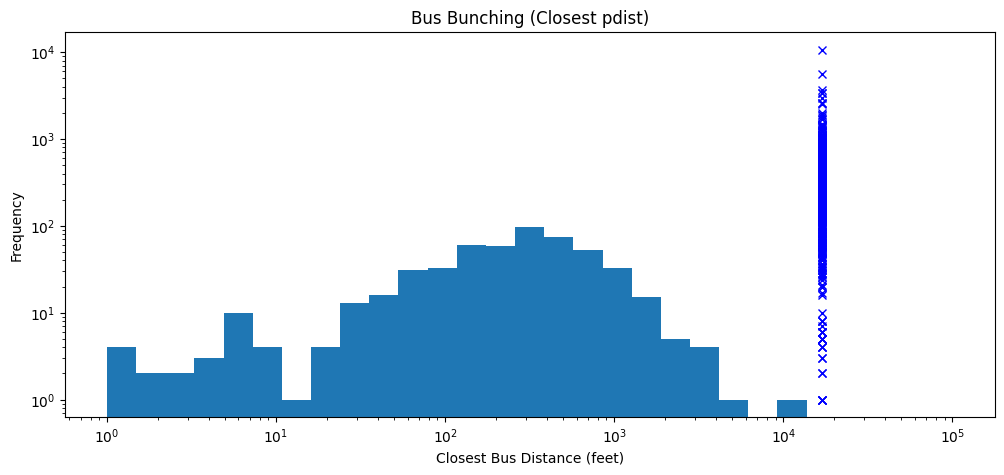

In [18]:
plt.figure(figsize=(12,5))
plt.semilogy(closest_pdist(load_data()).loc[4522], 'bx')  # Example pid
plt.xscale("log")
plt.hist(closest_pdist(load_data()).loc[4522], bins=np.logspace(0,5,30))
plt.xlabel('Closest Bus Distance (feet)')
plt.ylabel('Frequency')
plt.title('Bus Bunching (Closest pdist)')
plt.show()


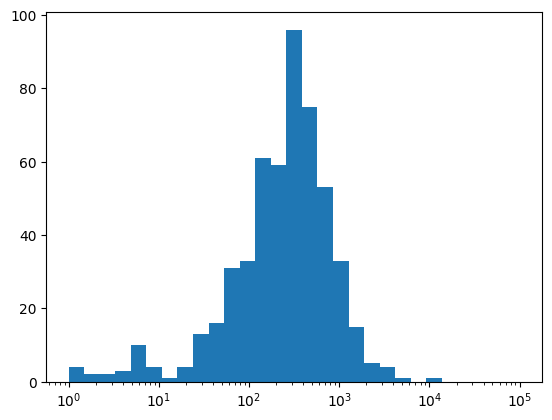

In [19]:
plt.xscale("log")
plt.hist(closest_pdist(load_data()).loc[4522], bins=np.logspace(0,5,30));